In [1]:
import math
import numpy as np

from math import sin, cos, atan2, sqrt
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [18]:
!pip install filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=9ffcb7528c8ec37e7f20217d7cc8442a53827c11918c24a79b1c36e355568206
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [19]:
from filterpy.kalman import KalmanFilter

In [2]:
df = pd.read_csv("/kaggle/input/th3-ts/th2.csv")

In [8]:
data = df.iloc[:,[0,11,12,13]]

In [9]:
data.head(15)

,date,11,12,13
0,1/1/2021,964.4,964.4,964.4
1,2/1/2021,1019.7,1019.7,1019.7
2,3/1/2021,988.4,988.4,988.4
3,4/1/2021,1010.8,1010.8,1010.8
4,5/1/2021,1061.5,1061.5,1061.5
5,6/1/2021,1061.5,1061.5,1061.5
6,7/1/2021,1061.5,1061.5,1061.5
7,8/1/2021,1061.5,1061.5,1061.5
8,9/1/2021,1064.1,1064.1,1064.1
9,10/1/2021,966.7,966.7,966.7


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    365 non-null    object 
 1   11      365 non-null    float64
 2   12      365 non-null    float64
 3   13      365 non-null    float64
dtypes: float64(3), object(1)
memory usage: 11.5+ KB


In [11]:
print(data.isnull().sum())


date    0
11      0
12      0
13      0
dtype: int64


In [12]:
data.describe()

,11,12,13
count,365.000000,365.000000,365.000000
mean,1040.311233,1040.311507,1040.312329
std,105.147265,105.147065,105.146765
min,885.700000,885.700000,885.700000
25%,988.400000,988.400000,988.400000
50%,1022.600000,1022.600000,1022.600000
75%,1061.500000,1061.500000,1061.500000
max,1565.500000,1565.500000,1565.500000


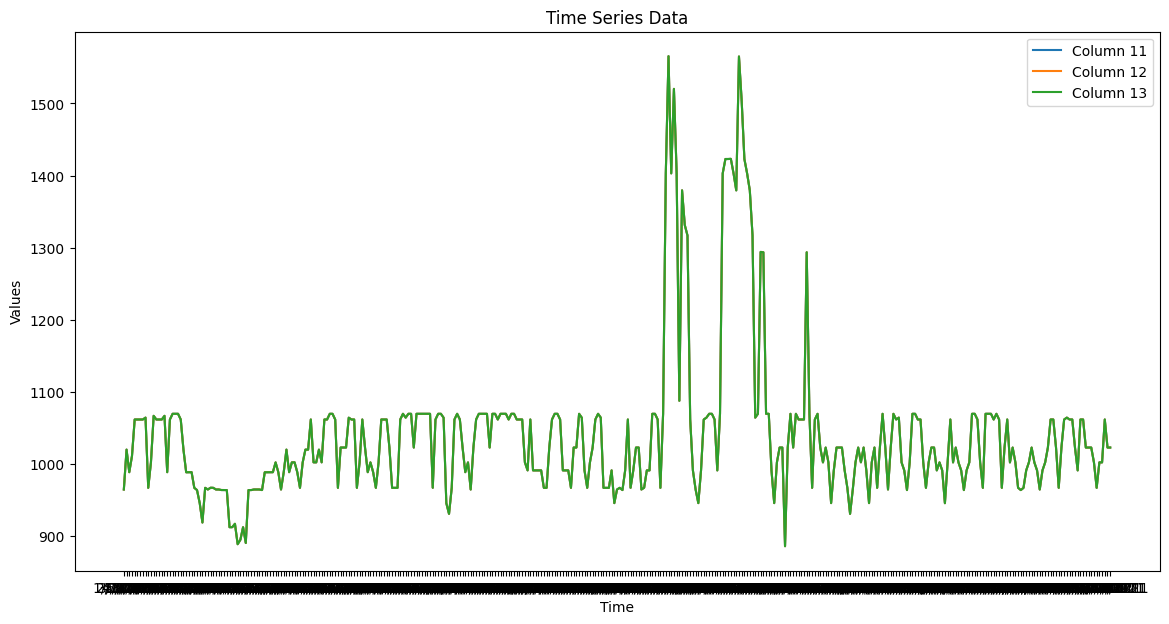

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(data['date'], data['11'], label='Column 11')
plt.plot(data['date'], data['12'], label='Column 12')
plt.plot(data['date'], data['13'], label='Column 13')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()
plt.show()


In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data[['11', '12', '13']])
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print(principal_df.head())


          PC1       PC2
0 -131.482903 -0.001054
1  -35.700493 -0.000872
2  -89.913684 -0.000975
3  -51.115746 -0.000901
4   36.699230 -0.000734


In [27]:
from sklearn.linear_model import LinearRegression

measurements = data['11'].values


train_size = int(len(measurements) * 0.8)
train_measurements = measurements[:train_size]
test_measurements = measurements[train_size:]
train_dates = data['date'][:train_size]
test_dates = data['date'][train_size:]

# Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([train_measurements[0], 0]) 
kf.F = np.array([[1, 1],
                 [0, 1]]) 
kf.H = np.array([[1, 0]]) 
kf.P = np.eye(2) * 1000  
kf.R = 5  
kf.Q = np.eye(2)  


train_predictions_kf = []
for measurement in train_measurements:
    kf.predict()
    kf.update(measurement)
    train_predictions_kf.append(kf.x[0])

test_predictions_kf = []
for measurement in test_measurements:
    kf.predict()
    kf.update(measurement)
    test_predictions_kf.append(kf.x[0])

kf.predict()
next_prediction_kf = kf.x[0]



Next prediction with Kalman Filter: 1032.7042964436753
Next prediction with Linear Regression: 1127.5099498104094


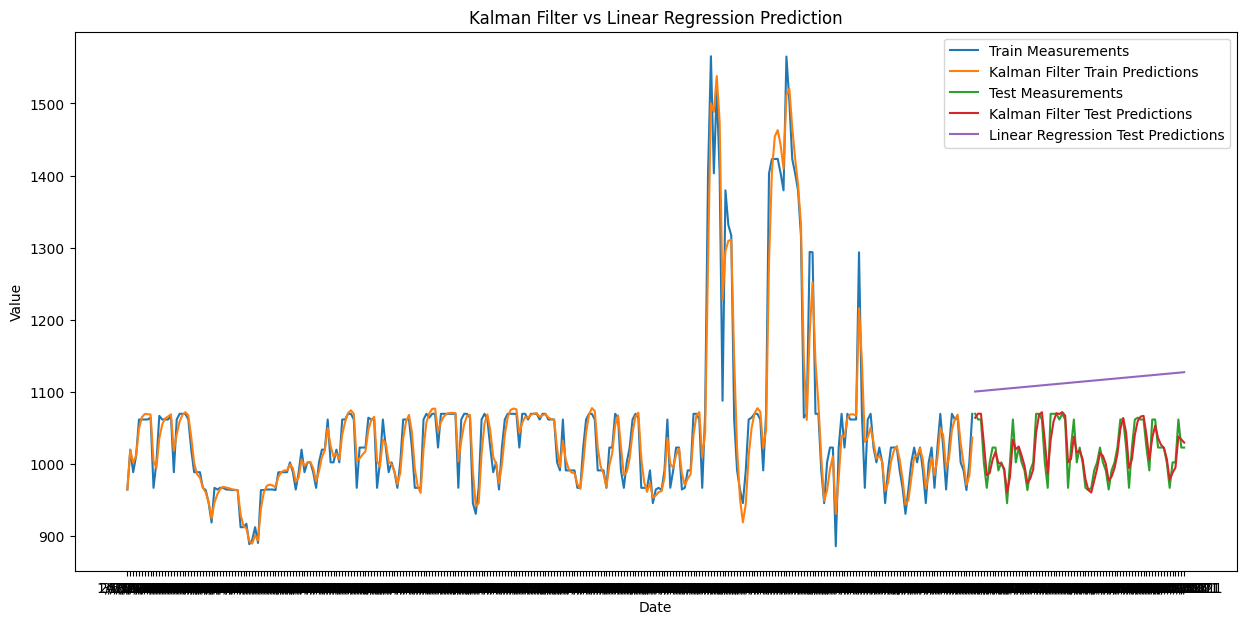

In [28]:
# Hồi quy tuyến tính
train_indices = np.arange(train_size).reshape(-1, 1)
test_indices = np.arange(train_size, len(measurements)).reshape(-1, 1)

linear_model = LinearRegression()
linear_model.fit(train_indices, train_measurements)

# Dự đoán trên tập huấn luyện và kiểm tra với hồi quy tuyến tính
train_predictions_lr = linear_model.predict(train_indices)
test_predictions_lr = linear_model.predict(test_indices)

# Dự đoán tiếp theo với hồi quy tuyến tính
next_prediction_lr = linear_model.predict(np.array([[len(measurements)]]))[0]

# In dự đoán tiếp theo
print("Next prediction with Kalman Filter:", next_prediction_kf)
print("Next prediction with Linear Regression:", next_prediction_lr)

# Vẽ đồ thị
plt.figure(figsize=(15, 7))
plt.plot(train_dates, train_measurements, label='Train Measurements')
plt.plot(train_dates, train_predictions_kf, label='Kalman Filter Train Predictions')
plt.plot(test_dates, test_measurements, label='Test Measurements')
plt.plot(test_dates, test_predictions_kf, label='Kalman Filter Test Predictions')
plt.plot(test_dates, test_predictions_lr, label='Linear Regression Test Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Kalman Filter vs Linear Regression Prediction')
plt.show()
